In [4]:
%load_ext autoreload
%matplotlib inline

In [5]:
%autoreload 2

import sys,os,glob
import psutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint

from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import cartopy.crs as ccrs

import datetime as dt
import re
import gc
import matplotlib.animation as animation
import warnings

# Own settings
from settings import *

workdir = os.getcwd()
moduledir, fcndir = defineDir(workdir)

## load TOOCAN
# from load_TOOCAN_DYAMOND_modif import load_TOOCAN_DYAMOND
from load_TOOCAN_DYAMOND_modif_BF import load_TOOCAN_DYAMOND

## current script object
thismodule = sys.modules[__name__]

Own modules available: ['conditionalstats', 'plot2D', 'plotCondPDFs', 'plot1D', 'conditionalstats_chunked']
Own modules available: ['fcns_load_DYAMOND_SAM', 'load_TOOCAN_DYAMOND_modif', 'load_TOOCAN_DYAMOND', 'load_TOOCAN_DYAMOND_modif_BF', 'casestudy', 'settings', 'fcns_load_RCEMIP_SAM']


In [6]:
from casestudy import *
from fcns_load_DYAMOND_SAM import *

In [7]:
region = '205E_250E_0N_20N'
DATA_PATH = '/data/bfildier/DYAMOND_REGIONS'
DIR_SAM_2D = os.path.join(DATA_PATH,region,'SAM/2D')

# Relation table

# Case study per region

1 variable for this region weights 22G. Need to implement DistributionChunked. Do this in object CaseStudy.

In [7]:
region = 'tropics'
varid = 'Prec'
mask = 'all'

In [8]:
cs_tropics = CaseStudy(name='DYAMOND-SAM',
                      region=region,
                      rel_tab_dyam_seg=loadRelTable('DYAMOND_SEG'))

    Load all time-dependent distributions

In [9]:
! ls /home/bfildier/analyses/explore-multiscale-extremes/results/tropics/Prec/all

time_slices.tar.gz


In [10]:
# ! rm -rf ../temp/*
! ls ../temp/

In [11]:
cs_tropics.setSimulationSpecs(i_t_min = 832,
                              i_t_max = 1917,
                              lat_slice=slice(-30,30))

for varid in 'Prec','PW':
    
    print(varid)
    
    for mask in 'all','PW_40':

        print('-',mask)

        # where sliced distributions are stored
        cs_tropics.setDirectories(region,varid,mask)

        # load all distributions
        cs_tropics.loadDistSliced(varid,mask)


Prec
- all
- PW_40
PW
- all
- PW_40


    Compute Pr distribution over all times

In [12]:
# compute mean precip time series
cs_tropics.computeMean(varid='Prec',mask='all')

# find "missing" time indices
cs_tropics.findTimeIndToIgnore()

In [13]:
# compute full distributions
for varid in 'Prec','PW':

    print(varid)
    
    for mask in 'all','PW_40':

        print('-',mask)
        cs_tropics.combineDistributions(varid,mask)

Prec
- all
- PW_40
PW
- all
- PW_40


In [14]:
# compute mean of PW above 40mm
cs_tropics.computeMean(varid='PW',mask='PW_40')

In [15]:
print(cs_tropics)
print('time indices to ignore:')
print(cs_tropics.times_to_ignore)

< CaseStudy object:
 . name: DYAMOND-SAM
 . region: tropics
 . rel_tab_dyam_seg: <class 'pandas.core.frame.DataFrame'>
 . i_t_min: 832
 . i_t_max: 1917
 . range_t: range(832, 1918)
 . lat_slice: slice(-30, 30, None)
 . lon_slice: None
 . dir_dist_pr_all_sliced: ../results/tropics/Prec/all
 . dict_dist_pr_all_sliced: <class 'dict'>
 . dir_dist_pr_PW_40_sliced: ../results/tropics/Prec/PW_40
 . dict_dist_pr_PW_40_sliced: <class 'dict'>
 . dir_dist_PW_all_sliced: ../results/tropics/PW/all
 . dict_dist_PW_all_sliced: <class 'dict'>
 . dir_dist_PW_PW_40_sliced: ../results/tropics/PW/PW_40
 . dict_dist_PW_PW_40_sliced: <class 'dict'>
 . pr_all_mean: [0.08895927 0.09020749 0.09127147 ... 0.0871079  0.08649893 0.08537947]
 . times_to_ignore: <class 'numpy.ndarray'>
 . dist_pr_all: <class 'conditionalstats_chunked.DistributionChunked'>
 . dist_pr_PW_40: <class 'conditionalstats_chunked.DistributionChunked'>
 . dist_PW_all: <class 'conditionalstats_chunked.DistributionChunked'>
 . dist_PW_PW_40: 

Compare variability in precipitation extremes and W in moist regions

(-10.0, 10.0)

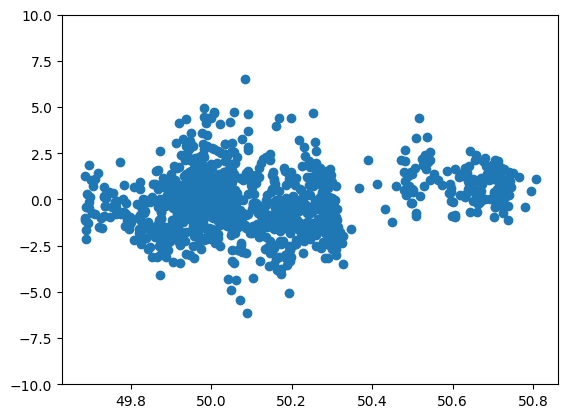

In [20]:
# Pext vs. mean PW above 40mm

rank_e = 99.999
i_e = cs_tropics.dist_pr_all.indexOfRank(rank_e)
    
# mask_to_ignore = np.zeros(cs_tropics.dist_pr_all.n, dtype=int)

pr_e = cs_tropics.dist_pr_all.percentiles[i_e]
dpr_ext = [d.percentiles[i_e] - pr_e for d in cs_tropics.dict_dist_pr_all_sliced.values()]
PW_above40 = cs_tropics.PW_PW_40_mean

fig,ax = plt.subplots()
ax.scatter(PW_above40,dpr_ext)
ax.set_ylim((-10,10))

(-6.0, 6.0)

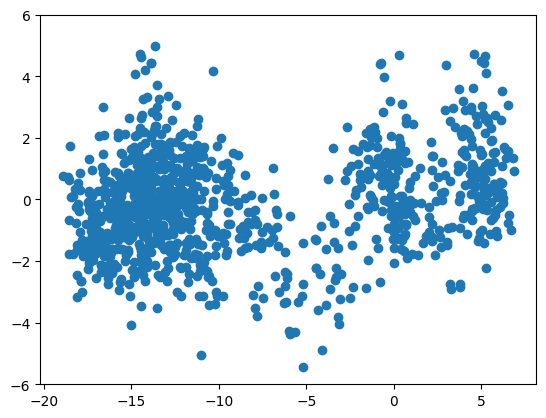

In [32]:
# Pext vs. PW 90th percentile

# Prec
rank_Pe = 99.999
i_Pe = cs_tropics.dist_pr_all.indexOfRank(rank_Pe)
pr_e = cs_tropics.dist_pr_all.percentiles[i_Pe]
dpr_e = [d.percentiles[i_Pe] - pr_e for d in cs_tropics.dict_dist_pr_all_sliced.values()]

# PW
rank_PWe = 99.9999
i_PWe = cs_tropics.dist_PW_all.indexOfRank(rank_PWe)
PW_e = cs_tropics.dist_PW_all.percentiles[i_PWe]
dPW_e = [d.percentiles[i_PWe] - PW_e for d in cs_tropics.dict_dist_PW_all_sliced.values()]

# Show
fig,ax = plt.subplots()
ax.scatter(dPW_e,dpr_e)
ax.set_ylim((-6,6))

[ 40.          43.87816272  47.08797441  49.7443692   51.90694801
  53.60976424  54.97201929  56.0788496   57.03242479  57.87532033
  58.6501008   59.36528758  60.04641218  60.70199601  61.33203517
  61.94505282  62.54103844  63.13702402  63.72449854  64.31196661
  64.89943714  65.48690806  66.0743796   66.67036458  67.27487164
  67.88787966  68.51792154  69.1564788   69.82057986  70.49319473
  71.18283112  71.88098894  72.59617488  73.30284102  74.00099192
  74.6906356   75.3547289   76.02735119  76.70847302  77.42365394
  78.19844041  79.03282157  79.95233924  80.94849328  82.04680379
  83.23877696  84.54994931  85.98031623  87.52987699  89.14755281
  90.74820645  92.18708769  93.45568829  94.57954152  95.58420544
  96.52075188  97.41472688  98.25762197  99.02389533  99.71353407
 100.33506046 100.90550963 101.437636   101.91017141 102.34864292
 102.75306444 103.14470689 103.53635474 103.91097989 104.23451247
 104.60061638 104.90712719 105.2051162  105.48607763 105.7627885
 106.090583

(81,)

# Case study over warm pool

In [6]:
cs_warmpool = CaseStudy(name='DYAMOND-SAM',
                       region='Warm Pool',
                       rel_tab_dyam_seg=loadRelTable('DYAMOND_SEG'))

In [7]:
coords_warmpool = [130,165,0,20] # Western Pacific Warm Pool

In [9]:
cs_warmpool.setSimulationSpecs(i_t_min = 832,
                              i_t_max = 1917,
                              lat_slice=slice(coords_warmpool[2],coords_warmpool[3]),
                              lon_slice=slice(coords_warmpool[0],coords_warmpool[1]))

# AFTER implementation of ChunkedDistribution AND computeMcsAgeOnPrDistribution

In [ ]:



            
# 3. combine diagnostics from all times in cs.dist_var (DistributionChunked)

#     # dist_var.combineMcsAgeComposites(N_all_bins,diag_all_bins,diag,metric)    # TODO    
    
# #     # add to case study
# #     writeDistInCaseStudy(cs,dist_var,varid,mask)
    
#     # save case study to disk
#     save_dir = os.path.join(DIR_OUT,"case_studies",name)
#     os.makedirs(save_dir,exist_ok=True)
#     pickle.dump(cs,open(os.path.join(save_dir,'case_study_%s_%s.pickle'%(region,mask),'wb'))
